## Building a GPT then extending it to make an Abstractive Summarizer maybe :)
## Note this notebook uses character tokenization and tinyshakespeare dataset 


In [1]:
# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2023-04-25 13:54:33--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.05s   

2023-04-25 13:54:33 (20.1 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [2]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [3]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1115394


In [4]:
# let's look at the first 1000 characters
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [5]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


## Tokenization process where here we use character tokenization instead of word tokenization

#(May change that later to subword tokenizer if we changed our dataset to a larger one)

In [6]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


## Import Pytorch

In [7]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


### let's now encode the entire text dataset and store it into a torch.Tensor

In [8]:
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000]) # the 1000 characters we looked at earier will to the GPT look like this

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
      

## Let's now split up the data into train and validation sets

In [9]:
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

Important thing to realize is we're never going to actually feed the entire text into Transformer all at once that would be computationally very expensive and prohibitive so when we
actually train a Transformer on a lot of these data sets we only work with chunks of the data set and when we train the
Transformer we basically sample random little chunks out of the training set and train them just chunks at a time and
these chunks have basically some kind of a length as a maximum length 

In [10]:
block_size = 8
train_data[:block_size+1]
# why +1 ?
# because we are predicting the next token based on all previous tokens
# by using 9 tokens we make 8 predictions since the first token is given as initialization for the sequence

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

## Language Modeling task where we predict next word given the previous words

In [11]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
# These are the eight examples hidden in a chunk of nine characters that we sampled from the training set 
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is tensor([18]) the target: 47
when input is tensor([18, 47]) the target: 56
when input is tensor([18, 47, 56]) the target: 57
when input is tensor([18, 47, 56, 57]) the target: 58
when input is tensor([18, 47, 56, 57, 58]) the target: 1
when input is tensor([18, 47, 56, 57, 58,  1]) the target: 15
when input is tensor([18, 47, 56, 57, 58,  1, 15]) the target: 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target: 58


## Important note 
while we're sampling we can start the sampling generation with as little as one character of context and the Transformer knows how to predict the next character with all the way up to just one context of one and so then it can predict everything up to block size and after block size we have to start truncating because the Transformer will never receive more than block size inputs when it's predicting the next character.
# Therefore Take care of block size , since if the input prompt is larger than it, We will truncate :(

## Batch Dimension

Okay so we've looked at the time dimension of the tensors that are going to be feeding into the Transformer there's one more Dimension to care about and that is the batch dimension 

---

so as we're sampling these chunks of text we're going to be actually every time
we're going to feed them into a Transformer we're going to have many batches of multiple chunks of text that are all like stacked up in a single
tensor and that's just done for efficiency just so that we can keep the gpus busy because they are very good at
parallel processing of data and so we just want to process multiple chunks all at the same
time but those chunks are processed completely independently they don't talk to each other

In [12]:
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    # generate batch_size(4) random numbers between (0, (len(data) - block_size))
    ix = torch.randint(len(data) - block_size, (batch_size,))
    # stack the independent sequences over each other to build the batch
    # where each stack start from a value from ix generated random numbers
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]], device='cuda:0')
targets:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]], device='cuda:0')
----
when input is [24] the target: 43
when input is [24, 43] the target: 58
when input is [24, 43, 58] the target: 5
when input is [24, 43, 58, 5] the target: 57
when input is [24, 43, 58, 5, 57] the target: 1
when input is [24, 43, 58, 5, 57, 1] the target: 46
when input is [24, 43, 58, 5, 57, 1, 46] the target: 43
when input is [24, 43, 58, 5, 57, 1, 46, 43] the target: 39
when input is [44] the target: 53
when input is [44, 53] the target: 56
when input is [44, 53, 56] the target: 1
when input is [44, 53, 56, 1] the target: 58
when input is [44, 53, 56, 1, 58] th

In [13]:
print(xb) # our input to the transformer

tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]], device='cuda:0')


## Simplest Possible Neural Network : Bigram Language Model

In [14]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # A simple lookup table that stores embeddings of a fixed dictionary and size.
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)
        # so what's happening here is that when we pass idx here every single integer in our input is going to refer to this
        # embedding table and is going to get a row of that embedding table corresponding to its index
    
    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
        # Pi torch is going to arrange all of this into a batch by Time by Channel tensor
        # in this case batch is 4, time is 8 and C which is the channels is vocab size 65.
        # logits which are basically the scores for the next character in the sequence
        logits = self.token_embedding_table(idx) # (B,T,C)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            # since pytorch cross_entropy function expects input to be in shape (minibatch, C)
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            # to measure a loss or like a quality of the predictions use the 
            # negative log likelihood loss which is implemented in pytorch under the name cross_entropy
            loss = F.cross_entropy(logits, targets)

        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            # call to the forward method of the BigramLanguageModel class.
            logits, loss = self(idx)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            
            # If you want to get most probable next token instead of sampling
            # idx_next = torch.argmax(probs, dim=1).view(-1,1) # (B, 1)

            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

m = BigramLanguageModel(vocab_size).to(device)
logits, loss = m(xb, yb)
print(logits.shape)
print(loss)

generated = m.generate(idx = torch.zeros((2, 1), dtype=torch.long, device=device), max_new_tokens=100)


torch.Size([32, 65])
tensor(4.8786, device='cuda:0', grad_fn=<NllLossBackward0>)


In [15]:
# They are not the same although they start with same token ' ', because we sample from distribution
# instead if we used argmax to get most probable token, they will be the same output
print(decode(generated[0].tolist()))
print(decode(generated[1].tolist()))


pYCXxfRkRZd
wc'wfNfT;OLlTEeC K
jxqPToTb?bXAUG:C-SGJO-33SM:C?YI3a
hs:LVXJFhXeNuwqhObxZ.tSVrddXlaSZaNe

!X:.yvvVwfMgFlxnAUe!$gm CXtgfFkzwQJ&yQ&QJs$FJdpxO CPbL-kobMtOiGvWmtxfk&ufNCeYS$SVws-!wfF.WT;nphaPbxu


## Parameters of previous model

Its expected to be vocab_size * vocab_size total parameters since we just save pair wise params for our look table

So its expected to be:  65 * 65 = 4225

In [16]:
from prettytable import PrettyTable
def count_parameters(model):
  table = PrettyTable(["Mod name", "Parameters Listed"])
  t_params = 0
  for name, parameter in model.named_parameters():
    if not parameter.requires_grad:
      continue
    param = parameter.numel()
    table.add_row([name, param])
    t_params+=param
  print(table)
  print(f"Sum of trained paramters: {t_params}")
  return t_params
count_parameters(m)

+------------------------------+-------------------+
|           Mod name           | Parameters Listed |
+------------------------------+-------------------+
| token_embedding_table.weight |        4225       |
+------------------------------+-------------------+
Sum of trained paramters: 4225


4225

## Create a PyTorch optimizer

In [17]:
# torch.optim.AdamW is an optimization algorithm used for training neural networks. 
# It is a variant of the popular Adam optimization algorithm that includes an additional weight decay term, which helps to prevent overfitting.
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

Step 0, loss 4.648484230041504
Step 1000, loss 3.7026753425598145
Step 2000, loss 3.123114585876465
Step 3000, loss 2.7292540073394775
Step 4000, loss 2.570060968399048
2.7019362449645996


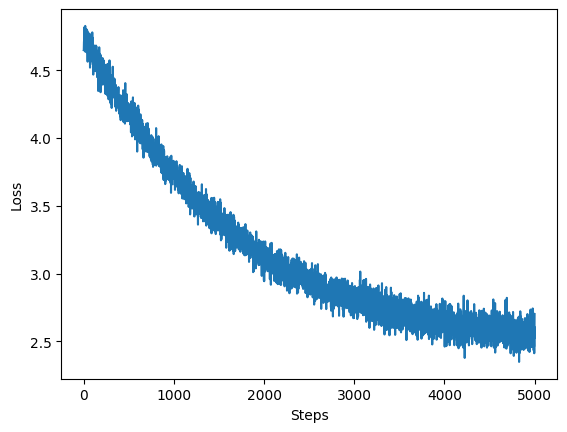

In [18]:
import matplotlib.pyplot as plt
batch_size = 32
loss_history = []

for steps in range(5000): # increase number of steps for good results... 
    
    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss

    # The forward method of the BigramLanguageModel is called with the input minibatch xb 
    # and the corresponding target minibatch yb. 
    # The output of the forward method is a tuple of (logits, loss). 
    # logits contains the predicted output logits of the model, and loss contains the loss calculated between the predicted output and the target output
    logits, loss = m(xb, yb)
    # append loss history to plot
    loss_history.append(loss.item())
    # This line clears the gradients of all the parameters in the optimizer. 
    # This is necessary because gradients are accumulated by default during backpropagation, 
    # and if we don't clear them, they will keep increasing on subsequent iterations.
    optimizer.zero_grad(set_to_none=True)
    
    # This line computes the gradients of the loss with respect to all the parameters of the model.
    # This is done by traversing the computation graph in reverse order and 
    # applying the chain rule to compute the gradients.
    loss.backward()
    
    # This line updates the parameters of the model using the gradients computed in the previous step.
    optimizer.step()

    # print loss every 1000 steps
    if steps % 1000 == 0:
        print(f'Step {steps}, loss {loss.item()}')

print(loss.item())
plt.plot(loss_history)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

## Even if we trained for millions of steps, you shouldn't expect shakespeare coming out from such model :)

Why? because its **Bigram** so generation of next token depends only on current token and no history !!

However, It shows that it learns something indeed if you compare the generated text now from above! 

In [19]:
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long, device=device), max_new_tokens=500)[0].tolist()))


Wawice my.

Onstacomzoroup
Yow&$FMOUf isth bot mil;KI!
WARCKI iree sengmin lat Heriliov ts, anend n nghir.
Swanousel lind me l.
MAull ce hiry:
Supr aisspllw y.
Jurinke n Boopetelaves
MP:

Pl, d metSSkllo W-S:
FourtCoiib3s the m dourivETENGShire s p-LOK:

PxTre

ALONomnterupt f s ar iris!
m:

Enge maleronth,
MadPre?d my o myr f-NLIE!
KENob&y, wardsal thisE:zLAnd uin cNI ayaraney Iry ts I&fr t c!
MykenEETon, bemary.
YoXy'WWh wne?m sora anghse.-e?nomangqqurien.
Sand tho-ze cin s th llugivod, wimerc


## The mathematical trick in self-attention

In [20]:
# toy example illustrating how matrix multiplication can be used for a "weighted aggregation"
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3))
a = a / torch.sum(a, 1, keepdim=True)
b = torch.randint(0,10,(3,2)).float()
c = a @ b
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


In [21]:
# consider the following toy example:

torch.manual_seed(1337)
B,T,C = 4,8,2 # batch, time, channels
x = torch.randn(B,T,C)
x.shape

torch.Size([4, 8, 2])

In [22]:
# We want x[b,t] = mean_{i<=t} x[b,i]
xbow = torch.zeros((B,T,C))
for b in range(B):
    for t in range(T):
        xprev = x[b,:t+1] # (t,C)
        xbow[b,t] = torch.mean(xprev, 0)


In [23]:
# version 2: using matrix multiply for a weighted aggregation
wei = torch.tril(torch.ones(T, T))
wei = wei / wei.sum(1, keepdim=True)
xbow2 = wei @ x # (T, T) @ (B, T, C) ----> (B, T, C)
# so it will cast wei to (B, T, T)
# so now : # (B, T, T) @ (B, T, C) ----> (B, T, C) where each of batch made in parallel
torch.allclose(xbow, xbow2)

True

In [24]:
# version 3: use Softmax
tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)
xbow3 = wei @ x
torch.allclose(xbow, xbow3)


True

In [25]:
# version 4: self-attention!
torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C)

# let's see a single Head perform self-attention
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x)   # (B, T, 16)
q = query(x) # (B, T, 16)
wei =  q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) ---> (B, T, T)

tril = torch.tril(torch.ones(T, T))
#wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)

v = value(x)
out = wei @ v
#out = wei @ x

out.shape

torch.Size([4, 8, 16])

## Very important for previous Self Attention code
Talking about a single batch only

TxT matrix
batch 1 : 
  
	q1k1 q1k2 .. q1kT
            
	q2k1 q2k2 .. q2kT
            
	..   ..   .. ..
            
	qTk1 qTk2 .. qTkT


values of batch 1 is T*16

	v11  v12  ... v1T

	v21  v22  ... v2T

	..   ..       ..

	vT1  vT2  ... vTT



wei @ values = T*16 matrix = weighted values 

	q1k1 v11 + q1k2 v21 + ...   q1k1 v12 + q1k2 v22 + ...
	q2k1 v11 + q2k2 v21 + ...   q2k1 v12 + q2k2 v22 + ...


note: wei@values (one batch)
 
 row i : it's affected by query i only and this query has dot product with all keys then this dot product act as weights for each value

 col j : you make weighted average for along jth dimension only of all the values

In [26]:
wei[0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
        [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
        [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
        [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]],
       grad_fn=<SelectBackward0>)

Notes:
- Attention is a **communication mechanism**. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.
- There is no notion of space. Attention simply acts over a set of vectors. This is why we need to positionally encode tokens.
- Each example across batch dimension is of course processed completely independently and never "talk" to each other
- In an "encoder" attention block just delete the single line that does masking with `tril`, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling.
- "self-attention" just means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module)
- "Scaled" attention additional divides `wei` by 1/sqrt(head_size). This makes it so when input Q,K are unit variance, wei will be unit variance too and Softmax will stay diffuse and not saturate too much. Illustration below

##Scaled attention and its use

In [27]:
# without using scaled attention
# the problem is if you have unit gaussian inputs so zero mean unit variance K and Q are unit caution and if you just do
# weight naively then you see that your weight's variance actually will be on the order of head size which in our
# case is 16. 
k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
wei = q @ k.transpose(-2, -1)
k.var()
q.var()
wei.var()

tensor(17.4690)

# So to overcome this 
If you multiply by one over head size square root so this is square root
and this is one over then the variance of weight will be one so it will be preserved

In [28]:
k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
wei = q @ k.transpose(-2, -1) * head_size**-0.5

In [29]:
k.var()

tensor(0.9006)

In [30]:
q.var()

tensor(1.0037)

In [31]:
wei.var()

tensor(0.9957)

# Why do we care about variance at all ? (Very Important !)

you'll notice that way here will feed weight into softmax and so it's really important especially at initialization that way be fairly diffuse

so in our case above here we sort of lucked out here and weight had a fairly diffuse numbers here so um like this now the problem is that because of softmax if weight takes on very positive and very negative numbers inside it softmax will actually converge towards one hot vectors

we don't want these values to be too extreme especially the
initialization otherwise softmax will be way too peaky and you're basically aggregating information from like a single node every node just aggregates information from a single other node that's not what
we want 

In [32]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1)

tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])

In [33]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5])*8, dim=-1) # gets too peaky, converges to one-hot

tensor([0.0326, 0.0030, 0.1615, 0.0030, 0.8000])

# Normalization 

In [34]:
class LayerNorm1d:
  # normalizing the rows of the batch not the columns as batchNorm
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    xmean = x.mean(1, keepdim=True) # batch mean
    xvar = x.var(1, keepdim=True) # batch variance
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

torch.manual_seed(1337)
module = LayerNorm1d(100)
x = torch.randn(32, 100) # batch size 32 of 100-dimensional vectors
x = module(x)
x.shape

torch.Size([32, 100])

In [35]:
x[:,0].mean(), x[:,0].std() # mean,std of one feature across all batch inputs

(tensor(0.1469), tensor(0.8803))

In [36]:
x[0,:].mean(), x[0,:].std() # mean,std of a single input from the batch, of its features

(tensor(-9.5367e-09), tensor(1.0000))

In [37]:
# French to English translation example:

# <--------- ENCODE ------------------><--------------- DECODE ----------------->
# les réseaux de neurones sont géniaux! <START> neural networks are awesome!<END>



### Full finished code, for reference

You may want to refer directly to the git repo instead though.

In [41]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 128 # how many independent sequences will we process in parallel?
block_size = 128 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 500
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 256
n_head = 4
n_layer = 4
dropout = 0.2
# ------------

torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

# @torch.no_grad() this line says to pytorch to prevent backprop since we will be evaluating not real training
@torch.no_grad()
def estimate_loss():
    out = {}
    # let model be in evaluation phase so layers like normalization, .. change their behaviour at inference time
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    # back to training phase
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.head_size = head_size
        # I'm creating this Trill variable Trill is not a parameter of the module so in sort of pytorch
        # conventions this is called a buffer it's not a parameter and you have to call it you have to assign it to the module
        # using a register buffer so that creates the trail, the triangle lower triangular Matrix
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        # we can also drop out here when we calculate the basically affinities and after the softmax we can drop out
        # some of those so we can randomly prevent some of the nodes from communicating
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * self.head_size**-0.5  # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        # a linear transformation layer that projects the concatenated output from the self.heads module to the original embedding size n_embd.
        self.proj = nn.Linear(n_embd, n_embd)
        
        # a dropout layer that randomly sets some of the output values to zero during training to prevent overfitting.
        # Dropout is something that you can add right before the residual connection back or right before the connection back into the original pathway
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # we run all of the heads in parallel into a list and simply concatenate all of the outputs and we're concatenating over the channel dimension
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        # The module is defined using the PyTorch nn.Sequential class, which allows us to define a sequence of layers that are applied to the input in order.
        # a feedforward neural network module with two linear layers, a ReLU activation function, and a dropout layer. 
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            # a dropout layer that randomly sets some of the output values to zero during training to prevent overfitting.
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        # n_head heads each of head_size-dimensional self attention running in parallel
        self.sa = MultiHeadAttention(n_head, head_size)

        # feedforward neural network purpose: before when we had the multi-headed self-attention only that did the communication, we went way too fast
        # to calculate the logits so the tokens looked at each other but didn't really have a lot of time to think on what they found from the other tokens
        # notice: that the feed forward here when it's applying linear this is on a per token level all the tokens do this independently so the self-attention is the communication and 
        # then once they've gathered all the data now they need to think on that data individually and so that's what feed forward is doing
        self.ffwd = FeedFoward(n_embd)

        # the size of the layer Norm here is n_embd of 32. so when the layer Norm is normalizing our features it is the normalization here
        # happens the mean and the variance are taking over 32 numbers so the batch and the time act as batch Dimensions both of
        # them so this is kind of like a per token transformation that just normalizes the features and makes them a unit mean unit gaussian at initialization
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        # this is actually something that slightly departs from the original paper you see that the [ADD and Norm] is applied after the transformation
        # but um in now it is a bit more basically common to apply the layer Norm before the transformation so there's a reshuffling of the layer Norms 
        # so this is called the [pre-norm formulation] and that's the one that we're going to implement as well
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        # take care now embedding size (= n_embd) != vocab size 
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        # positional encoding lookup 
        self.position_embedding_table = nn.Embedding(block_size, n_embd)

        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        
        # final layer norm at the end of the transfomer
        self.ln_f = nn.LayerNorm(n_embd) 
        
        # a fully connected (linear) layer by performing a linear transformation on the input tensor
        # with a weight matrix of size (n_embd, vocab_size) and adding a bias vector of size (vocab_size,)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        
        # now total embedding = token embedding + positional embedding
        x = tok_emb + pos_emb # (B,T,C)
        
        # pass x into
        x = self.blocks(x) # (B,T,C)
        # pass x into
        x = self.ln_f(x) # (B,T,C)

        # logits is the ouput of the fully connected (linear) layer now given input x
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):

            # because now we're using positional embeddings we can never have more than block size coming in because if idx is
            # more than block size then our position embedding table is going to run out of scope because it only has embeddings for up to block size 
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))


3.222593 M parameters
step 0: train loss 4.2969, val loss 4.2924
step 500: train loss 1.5916, val loss 1.7564
step 1000: train loss 1.4001, val loss 1.6054
step 1500: train loss 1.3235, val loss 1.5582
step 2000: train loss 1.2739, val loss 1.5163
step 2500: train loss 1.2402, val loss 1.5024
step 3000: train loss 1.2128, val loss 1.4977
step 3500: train loss 1.1920, val loss 1.4926
step 4000: train loss 1.1713, val loss 1.4873
step 4500: train loss 1.1540, val loss 1.4972
step 4999: train loss 1.1367, val loss 1.4908

 HENRY VI:
O Dorroh as science endirely hangs a hiselent,
That you can inforcement
That gentlewoman: women, I may long fear
To answer writing your flowers; but the ground, tenders to say
That I'll hear a devise with him, reser's:
The morning of affair hath proffess'd your fond,
Has hugg'd upon my moving father shall hear by,
In peace out on mine and sign away;
And bid that York; and the pitning of the
body had been been side by that which full of it.

GEORGE:
Lords, are 